** Notes ** <br>
To regenerate input data:
* re-extract lists of rSNP (from HGMD) and/or cSNPs (from UCSC)  
```
../src/bash/get_rSNPs_from_local_hgmd.sh
../src/bash/get_control-SNPs_from_UCSC.sh
```
* get metadata for above (from UCSC)
```
../src/bash/get_SNP_metadata_from_UCSC.sh csnps.rslist.txt csnps.ucsc_metadata.txt
../src/bash/get_SNP_metadata_from_UCSC.sh rsnps.rslist.txt rsnps.ucsc_metadata.txt
```

To Generate PDF: 
```
cd notes/; ipython nbconvert --to pdf GWASTool.ipynb
```

In [2]:
import sys, os
import pandas as pd
import numpy as np
import sklearn as sk
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics #roc_curve, auc, accuracy_score, roc_auc_score
from sklearn.cross_validation import train_test_split
import matplotlib.pyplot as plt
%matplotlib inline

pd.set_option('display.max_columns', 500) 

# Switch to workspace (launch @ <PROJECT_HOME>/notes/ OR <>/workspace/)
os.chdir("../workspace/")
# os.listdir(".")

In [3]:
# Load and Concat training + test datasets
positive = pd.read_csv("rsnps.ucsc_metadata.txt", sep='\t').fillna(0)
unlabeled = pd.read_csv("csnps.ucsc_metadata.txt", sep='\t').fillna(0)

# Add TSS (Transcription Start Site) metadata to above
positiveTSS = pd.read_csv("rsnps.tss_metadata.txt", sep='\t')
unlabeledTSS = pd.read_csv("csnps.tss_metadata.txt", sep='\t')
positive = positive.merge(positiveTSS, on='name')
unlabeled = unlabeled.merge(unlabeledTSS, on='name')

# Add label
positive['label'] = 1
unlabeled['label'] = 0

alldata = pd.concat([positive, unlabeled]) # concat rows
print "Positive cases (%d) + Negative cases (%d) = Total (%d)" % \
    (len(positive), len(unlabeled), len(alldata))

# alldata.to_csv("alldata.csv")
# print alldata.head()
# print alldata.tail()

Positive cases (2381) + Negative cases (6144) = Total (8525)


Features in the model
* chr: Chromosome
* majorAllele, minorAllele
* DHS_SourceCount: DNase1 Hypersensitive Site Count 
* num_tfs: Number of overlapping TF Binding Sites 
* phastCons: Phylogenetic Conservation (over 46 placental mammals) sumScore/validCount 
* tssDistance: Distance from nearest Transcription Start Site, +/- depending on strand

In [5]:
# Set up design-matrix
# UCSC SNP142 Schema Notes: http://ucscbrowser.genap.ca/cgi-bin/hgTables?db=hg19&hgta_group=varRep&hgta_track=snp135&hgta_table=snp135&hgta_doSchema=describe+table+schema

# extract first two alleles from UCSC column 'alleles'
alleleFeature = alldata.alleles.str.split(',').tolist()
alleleFeature = [[] if x is np.nan else x[0:2] for x in alleleFeature]
alleleFeature = pd.DataFrame(alleleFeature, columns="majorAllele minorAllele".split())
alldata = alldata.merge(alleleFeature, left_index=True, right_index=True)

# TFBS: text-to-columns 
tfbsOneHot = alldata['tf_names'].str.get_dummies(sep=',') # 158 TFBS columns
alldata = alldata.merge(tfbsOneHot, left_index=True, right_index=True)

# Create R-formula for the fit
from patsy import dmatrices, dmatrix
formula = 'label ~ C(chrom) + C(majorAllele) + C(minorAllele) + \
    DHS_SourceCount + num_tfs + phastCons + tssDistance + '
formula += " + ".join(tfbsOneHot.columns[1:])

# create data-matrix
y, X = dmatrices(formula, alldata, return_type="dataframe")
y = np.ravel(y)

print "#y:%d, #x.rows:%d, #x.cols:%d" % (len(y), len(X), len(X.columns))

#y:11774, #x.rows:11774, #x.cols:257


In [ ]:
# shuffle and split into (1) model building  and (2) model-comparison/holdout sets
holdoutFraction = 0.25
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=holdoutFraction, random_state=1337)

In [6]:
# Fit random forest
# n_estimators: doesn't need tuning
# class_weight: see http://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html
classifier = RandomForestClassifier(n_estimators=100, oob_score=True, 
                                    class_weight=None, n_jobs=-1)

model = classifier.fit(X_train, y_train)
print model

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=-1,
            oob_score=True, random_state=None, verbose=0, warm_start=False)


In [7]:
# Report fit and feature-importance

# oob_error = 1 - clf.oob_score_ : http://scikit-learn.org/stable/auto_examples/ensemble/plot_ensemble_oob.html
print "OOB Error : ", (1 - model.oob_score_)

# Training Accuracy 
print "Training Accuracy: ", classifier.score(X, y)

# Null Class Accuracy
# pos, unlab = y.iloc[:,0].mean(), y.iloc[:,1].mean()
pos, unlab = y.mean(), 1 - y.mean()
print "Null Class Accuracy: %%positive: %.2f, %%unlabled: %.2f \n" % (pos, unlab)

# Feature importance
featureImportances = model.feature_importances_
featureImportances = 100.0 * (featureImportances / featureImportances.sum()) #Normalize
topFeatures = pd.DataFrame(featureImportances, index=[X.columns], columns=['Importance'])
topFeatures = topFeatures.sort(columns='Importance', ascending=False)
print "Feature Importances (Normalized): \n", topFeatures.head(15), "\n"

# http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html
# oob_decision_function_ : array of shape = [n_samples, n_classes]
# votingFractions = model.oob_decision_function_
# print votingFractions, "\n" # pd.DataFrame()

OOB Error :  0.301359003398
Training Accuracy:  0.924749447936
Null Class Accuracy: %positive: 0.38, %unlabled: 0.62 

Feature Importances (Normalized): 
                     Importance
tssDistance           22.569494
phastCons             14.394134
num_tfs                6.014059
DHS_SourceCount        5.754301
C(minorAllele)[T.G]    1.518433
C(majorAllele)[T.C]    1.437801
C(majorAllele)[T.A]    1.410987
C(minorAllele)[T.T]    1.317768
C(minorAllele)[T.C]    1.135656
C(chrom)[T.chr11]      0.873133
C(majorAllele)[T.G]    0.774745
EZH2                   0.759017
CTCF                   0.740543
C(chrom)[T.chr10]      0.734463
C(chrom)[T.chr12]      0.694933 



Holdout Accuracy:  0.704144021739
(compare with) OOB Error:  0.301359003398
Null Class Accuracy (holdout): %positive 0.39, %unlabeled 0.61
ROC AUC: 0.725883658036 

             precision    recall  f1-score   support

        0.0       0.73      0.81      0.77      1785
        1.0       0.65      0.54      0.59      1159

avg / total       0.70      0.70      0.70      2944



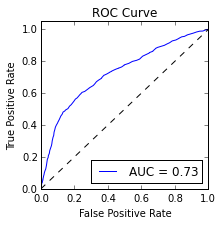

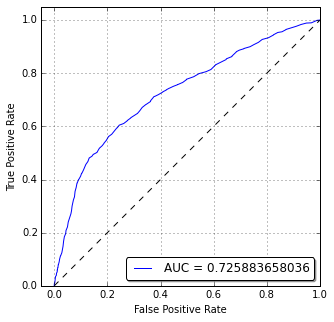

In [8]:
# Holdout Accuracy 
y_test_predicted = classifier.predict(X_test)
y_test_probs = classifier.predict_proba(X_test)
print "Holdout Accuracy: ", classifier.score(X_test, y_test) 
# metrics.accuracy_score(y_test, y_test_predicted) # holdout accuracy (alt. method)
print "(compare with) OOB Error: ", (1 - model.oob_score_)
print "Null Class Accuracy (holdout): %%positive %.2f, %%unlabeled %.2f" % (y_test.mean(), 1 - y_test.mean())

# Report AUROC 
roc_auc = metrics.roc_auc_score(y_test, y_test_probs[:,1])
print "ROC AUC:", roc_auc, "\n"

# print metrics.confusion_matrix(y_test, y_test_predicted) 
print metrics.classification_report(y_test, y_test_predicted)

# Get ROC Curve Data
fpr, tpr, thresholds = metrics.roc_curve(y_test, y_test_probs[:,1])

# Plot ROC
plt.figure(figsize=(3,3))
plt.plot(fpr, tpr, label='AUC = %0.2f' % roc_auc)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.show()

# make the plot
plt.figure(figsize=(5,5))
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([-0.05, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.grid(True)
plt.plot(fpr, tpr, label='AUC = {0}'.format(roc_auc))        
plt.legend(loc="lower right", shadow=True, fancybox =True) 
plt.show()

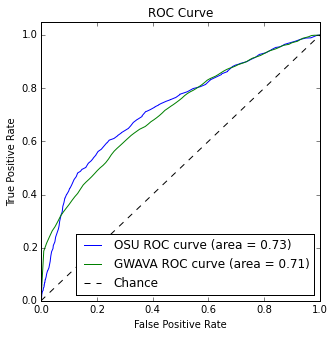

In [9]:
# Compare this ROC with GWAVA (directly compare with "region-matched" ROC data)
gwava_roc_data = pd.read_csv("../data/GWAVAv1.0/paper_data/region_roc.csv")
fpr1, tpr1, auc1 = gwava_roc_data.fpr, gwava_roc_data.tpr, gwava_roc_data.auc[1]

# Plot ROC
plt.figure(figsize=(5,5))
plt.plot(fpr, tpr, label='OSU ROC curve (area = %0.2f)' % roc_auc)
plt.plot(fpr1, tpr1, label='GWAVA ROC curve (area = %0.2f)' % auc1)
plt.plot([0, 1], [0, 1], 'k--', label='Chance')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.show()



In [10]:
# Compare this ROC with GWAVA "region-matched" predictions
gwava_data = pd.read_csv("../data/GWAVAv1.0/paper_data/region_annotation.csv")
len(gwava_data) # 5027 rows
gwava_data.rename(columns={'Unnamed: 0': 'SNP'}, inplace=True)
gw = gwava_data.loc[:, ["SNP", "cls"]]
gw.describe() # seems like cls=0 everywhere

s1 = set(alldata.name) # 7969
s1 = set(positive.name) # 2156
len(s1) 

s2 = set(gw.SNP)
len(s2) # 5027

inter = s1.intersection(s2)
len(inter) # 355 (with alldata), 56 (with positive)

# Alt. file -- can't load!
# from pandas import read_pickle 
# gwava_data = read_pickle("../data/GWAVAv1.0/training_sets/matched_by_region.bed")

54